## CHAOS-6-Core - Hight Order Interpolation of the SH Coefficients


### 1) Load SHC model file

In [1]:
from os.path import basename
from eoxmagmod.data import IGRF12 as SHC_MODEL_FILE
from eoxmagmod.data import CHAOS6_CORE_LATEST as SHC_MODEL_FILE

print(basename(SHC_MODEL_FILE))
print(open(SHC_MODEL_FILE).read())

CHAOS-6-x7_core.shc
# CHAOS-6-x7 core field model                      
# Based on model iteration_1 of CF_CHAOS_09d_18.mat
# extracted on 09-Oct-2018 12:11:25                
  1  20 221   6   5
          1997.1020   1997.2019   1997.3018   1997.4018   1997.5017   1997.6016   1997.7016   1997.8015   1997.9014   1998.0014   1998.1013   1998.2012   1998.3012   1998.4011   1998.5010   1998.6010   1998.7009   1998.8008   1998.9008   1999.0007   1999.1006   1999.2005   1999.3005   1999.4004   1999.5003   1999.6003   1999.7008   1999.8012   1999.9017   2000.0022   2000.1027   2000.2026   2000.3025   2000.4025   2000.5024   2000.6023   2000.7023   2000.8022   2000.9021   2001.0021   2001.1020   2001.2019   2001.3018   2001.4018   2001.5017   2001.6016   2001.7016   2001.8015   2001.9014   2002.0014   2002.1013   2002.2012   2002.3012   2002.4011   2002.5010   2002.6010   2002.7009   2002.8008   2002.9008   2003.0007   2003.1006   2003.2005   2003.3005   2003.4004   2003.5003   2003.6003   20

/home/pacesm/conda/lib/python3.7/site-packages/spacepy/pycdf/__init__.py:1209: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class CDF(collections.MutableMapping):


### 2) Get coefficients at the interpolation nodes

In [2]:
from numpy import empty
from eoxmagmod import mjd2000_to_decimal_year
from eoxmagmod.magnetic_model.loader_shc import load_coeff_shc

degree2offset = lambda d: (d*(d + 1))//2

model_coeff = load_coeff_shc(SHC_MODEL_FILE)

times = model_coeff._times

# get full matrix of the SH coefficients
coefficients = empty((times.size, degree2offset(model_coeff.degree + 1), 2))

for idx, time in enumerate(times):
    coefficients[idx, ...], _ = model_coeff(time)

print(coefficients.shape)

(221, 231, 2)


### 3) Piecewise polynomial interpolation

In [3]:
from numpy import asarray, ones, arange, prod, digitize
from numpy.lib.stride_tricks import as_strided



class LBInterpolator(object):
    """1D Piecewise polynomial interpolation based on the barycentric Lagrange
    polynomial form.

    The constructor expects sorted N*(order - 1) + 1 unique nodes where N is
    the number of the piecewise interpolation intervals.
    """

    @staticmethod
    def _get_weights(nodes):
        """ Get array of barycentric Lagrange polynomial weights.
        """
        count, order = nodes.shape
        tmp = ones((count, order))
        for idx in range(order):
            x_i = _expand(nodes[:, idx], order - 1)
            x_j = nodes[:, arange(idx+1, idx+order) % order]
            tmp[:, idx] = prod(x_i - x_j, axis=1)
        return 1./tmp

    def __init__(self, order, nodes):
        step = max(order - 1, 1)
        nodes = asarray(nodes)

        if order < 1:
            raise ValueError("Invalid polynomial order %s!" % order)

        if nodes.ndim != 1:
            raise ValueError("One dimensional array of nodes expected.")

        if (order > 2 and nodes.size % step != 1) or (order < 2 and nodes.size != order):
            raise ValueError(
                "The %d nodes does not match the polynomial order %d!"
                % (nodes.size, order)
            )

        self.order = order
        self.size = nodes.size
        self.count = (nodes.size - 1)// step
        self.breaks = nodes[::step]
        self.index = _reshape(arange(nodes.size), order)
        self.nodes = nodes[self.index]
        self.weights = self._get_weights(self.nodes)

    def get_intv_and_dx(self, x):
        """ Locate iterval and diferences to nodes. """
        # pylint: disable=invalid-name
        x = asarray(x)
        order = self.order
        intv_max = self.breaks.size - 2
        # find the PP intervals
        intv = asarray(digitize(x, self.breaks) - 1) # O(ln(n_intv) * n_x)
        # extrapolation of the first and last PP
        intv[intv < 0] = 0
        intv[intv > intv_max] = intv_max
        dx = _expand(x, order) - self.nodes[intv, :] # A * n_x * order
        return intv, dx

    def get_basis(self, x, basis_class=None):
        """ Get the PPBasis object for the given x coordinates. """
        # pylint: disable=invalid-name
        return (basis_class or LBBasis)(self, x)


class PPBasis(object):
    """ Base class for basis functions for the fixed x position.
    """
    # pylint: disable=too-few-public-methods
    def __init__(self, size, index, basis):
        self.size = size
        self.index = index
        self.basis = basis

    def __call__(self, values):
        """ Evaluate the interpolation polynomial as the dot product of
        the basis and node values.
        """
        values = asarray(values)
        if self.size != values.shape[-1]:
            raise ValueError(
                "Shape mismatch between the nodes(x) and interpolated "
                "values (y)!"
            )
        return (self.basis * values[..., self.index]).sum(axis=-1)


class LBBasis(PPBasis):
    """ Lagrange Polynomial basis for the fixed x position.
    This class uses the O(order^2) form (no division by zero).
    """
    # pylint: disable=too-few-public-methods

    def __init__(self, interpolator, x):
        # pylint: disable=invalid-name
        # locate the intervals and get differences to the nodes
        intv, dx = interpolator.get_intv_and_dx(x)
        # evaluate basis functions
        order = interpolator.order
        basis = interpolator.weights[intv, :]
        for idx in range(order):
            basis[..., idx] *= prod(
                dx[..., arange(idx+1, idx+order) % order], axis=-1
            )
        PPBasis.__init__(
            self, interpolator.size, interpolator.index[intv, :], basis
        )
        
        
class LBBasisD(PPBasis):
    """ Lagrange Polynomial derivatives basis for the fixed x position.
    """
    # pylint: disable=too-few-public-methods

    def __init__(self, interpolator, x, derivative):
        # pylint: disable=invalid-name
        # locate the intervals and get differences to the nodes
        intv, dx = interpolator.get_intv_and_dx(x)
        scale = prod(arange(1, derivative + 1))
        
        # evaluate basis functions
        order = interpolator.order
        basis = interpolator.weights[intv, :]
        
        for idx0, idxset in enumerate(lidx(order, derivative)):
            tmp = 0
            for idx in idxset:
                tmp += prod(dx[..., idx], axis=-1)
            basis[..., idx0] *= scale * tmp
        PPBasis.__init__(
            self, interpolator.size, interpolator.index[intv, :], basis
        )

        
class LBBasisD1(LBBasisD):
    """ Lagrange Polynomial 1st derivative basis for the fixed x position.
    """
    def __init__(self, interpolator, x):
        LBBasisD.__init__(self, interpolator, x, derivative=1)

        
class LBBasisD2(LBBasisD):
    """ Lagrange Polynomial 2nd derivative basis for the fixed x position.
    """
    def __init__(self, interpolator, x):
        LBBasisD.__init__(self, interpolator, x, derivative=2)


def lidx(order, nsteps):
    """ generate indices of the Lagrange polynomials """
    idx = tuple(range(order))
    return [
        set(_lidx(idx[:i] + idx[i+1:], nsteps-1))
        for i in range(order)
    ]


def _lidx(idx0, nsteps):
    if nsteps >= 0:
        for i in range(len(idx0)):
            for idx in _lidx(idx0[:i] + idx0[i+1:], nsteps-1):
                yield idx
    else:
        yield idx0


def _reshape(data, order):
    """ Reshape the given 1D array so that each row corresponds to one
    interpolation interval.
    """
    if order <= 1:
        return data.reshape((data.size, order))

    sizeof, = data.strides
    step = order - 1
    return as_strided(data, ((data.size - 1)//step, order), (step*sizeof, sizeof))


def _expand(data, size):
    """ Expand an array by adding new dimension and repeating the elements.
    """
    return as_strided(data, data.shape + (size,), data.strides + (0,))


### 3) Plot coefficients

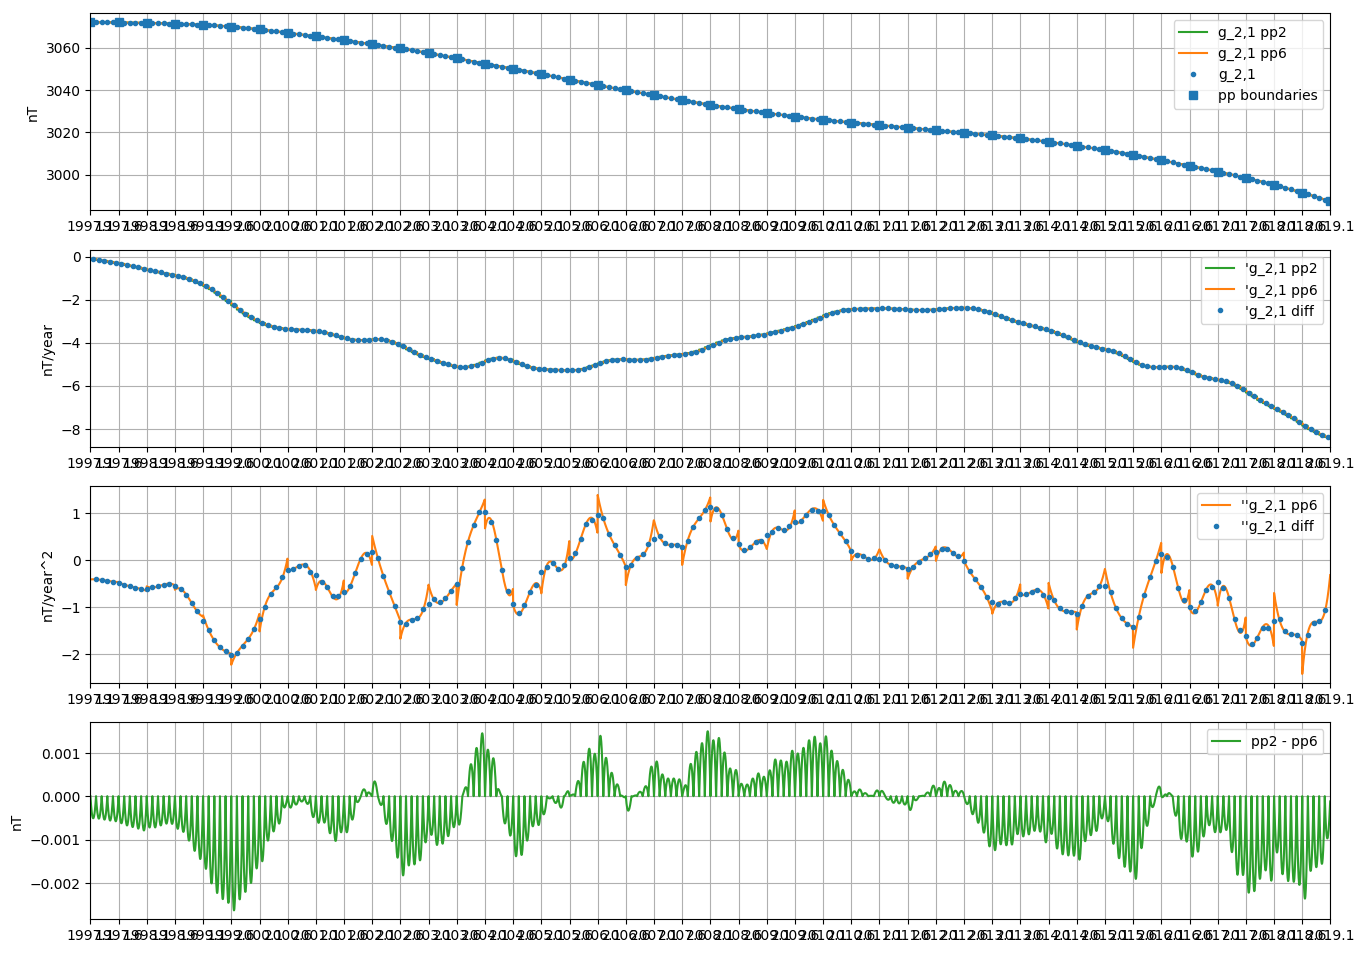

In [5]:
from math import pi
from numpy import any, hypot, arctan2, linspace, concatenate
from matplotlib import pyplot as plt

# select coefficient degree and order
degree, order = 2, 1


idx = degree2offset(degree) + order

times0 = mjd2000_to_decimal_year(model_coeff._times)


# G - coefficients
values0 = coefficients[:, idx, 0]
label = ('g_%d,%d' % (degree, order))

# H - coefficients
#values0 = coefficients[:, idx, 1]
#label = ('h_%d,%d' % (degree, order))

#values0 = hypot(coefficients[:, idx, 0], coefficients[:, idx, 1])
#phase0 = arctan2(coefficients[:, idx, 1], coefficients[:, idx, 0]) * (180/pi)
#label = ('|gh|_%d,%d' % (degree, order))


def differentiate(x, y):
    return (
        0.5*(x[1:] + x[:-1]),
        (y[1:] - y[:-1])/(x[1:] - x[:-1])
    )


times1, values1 = differentiate(times0, values0)
times2, values2 = differentiate(times1, values1)


pporder = 6
ppstep = max(1, pporder - 1)
ppint = LBInterpolator(pporder, times0)
pplin = LBInterpolator(2, times0)

times_b = times0[::pporder-1]
values_b = values0[::pporder-1]


N = 25
times_int = concatenate([
    times0[:-1] + (i/N)*(times0[1:] - times0[:-1]) for i in range(N)
])
times_int.sort()
values0_int = ppint.get_basis(times_int)(values0)
values1_int = ppint.get_basis(times_int, LBBasisD1)(values0)
values2_int = ppint.get_basis(times_int, LBBasisD2)(values0)

values0_lin = pplin.get_basis(times_int)(values0)
values1_lin = pplin.get_basis(times_int, LBBasisD1)(values0)


#times_b = times0[::5]

#lim = (2010, 2019)
lim = (times0.min(), times0.max())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig = plt.figure(figsize=(16, 12), dpi=100)

plt.subplot(411)
plt.plot(times_int, values0_lin, '-', label=label + ' pp2', color=colors[2])
plt.plot(times_int, values0_int, '-', label=label + ' pp6', color=colors[1])
plt.plot(times0, values0, '.', label=label, color=colors[0])
plt.plot(times_b, values_b, 's', label="pp boundaries", color=colors[0])
plt.legend()
#help(plt)
plt.xticks(times_b)
plt.xlim(*lim)
plt.ylabel("nT")
plt.grid()

plt.subplot(412)
plt.plot(times_int, values1_lin, '-', label="'" + label + ' pp2', color=colors[2])
plt.plot(times_int, values1_int, '-', label="'" + label + ' pp6', color=colors[1])
plt.plot(times1, values1, '.', label="'" + label + ' diff')
plt.legend()
plt.xticks(times_b)
plt.xlim(*lim)
plt.ylabel("nT/year")
plt.grid()

plt.subplot(413)
plt.plot(times_int, values2_int, '-', label="''" + label + ' pp6', color=colors[1])
plt.plot(times2, values2, '.', label="''" + label + ' diff')
plt.legend()
plt.xticks(times_b)
plt.xlim(*lim)
plt.ylabel("nT/year^2")
plt.grid()

plt.subplot(414)
plt.plot(times_int, values0_lin - values0_int, '-', label='pp2 - pp6', color=colors[2])
#plt.plot(times0, phase0, '.', label="phase")
plt.legend()
plt.xticks(times_b)
plt.xlim(*lim)
plt.ylabel("nT")
#plt.ylabel("degree")
plt.grid()


#plt.plot(times, values, '.', label=('|gh|_%d,%d' % (degree, order)))
#plt.plot(0.5*(times[1:] + times[:-1]), (values[1:] - values[:-1])/(times[1:] - times[:-1]), '.', label=('|gh|_%d,%d' % (degree, order)))